In [1]:
#source("https://bioconductor.org/biocLite.R")
#biocLite('Biobase')
#biocLite('GEOquery')

library(NMF)
library(matrixStats)
library(Biobase)
library(GEOquery)
library(matrixStats)



Loading required package: pkgmaker
Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:base':

    isNamespaceLoaded

Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: windows] | Cores 3/4
matrixStats v0.51.0 (2016-10-08) successfully loaded. See ?matrixStats for help.

Attaching package: 'matrixStats'

The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)


In [9]:
VD_NMF <- function(
    gseNum = 'GSE21501',         #GSE dataset to extract expression values from.  21501 = Pancreatic cancer microarrays.

    k = 14,                      #User's guess for a reasonable number of factorrs.
    k_low = k - 2,               #Lower bound for the range of factors tested by nmf.
    k_high = k + 2,              #Upper bound for the range of factors tested by nmf.
    num_runs = 10,               #Number of NMF runs.  This can also be changed to run to convergence.
    nmf_method = 'brunet',       #Specific NMF algorithm to use.  See NMF library for options.  

    num_genes = 500,             #TESTING VARIABLE: restricted number of genes for run time.
    top_gene_cutoff = 50,        #TESTING VARIABLE: restricted number of top genes for run time.
    num_samples = 132
    )
    
    {
    #retrieve specified dataset, convert to nonnegative format, and run initial NMF to determine appropriate k value.
    gse <- getGEO(gseNum, GSEMatrix=TRUE)
    exprSetGSE <- gse[[1]]
    
    input_exprs <- exprs(exprSetGSE)
    unlog_exprs <- (2^input_exprs) + 1
    nn_exprs <- log2(unlog_exprs)

    #TESTING VARIABLE
    sub_nn_exprs <- nn_exprs[1:num_genes,]    
    
    nmf_res <- nmf(sub_nn_exprs, seq(k_low, k_high, 1), nrun = num_runs, method=nmf_method, .opt = "v")
    
    plot(nmf_res)

    #Cophenetic coefficient is an expression (0-1) of how consistently samples are assigned to the same cluster over
    #iterations of the NMF.
    
    sum_nmf <- summary(nmf_res)
    k_list <- seq(k_low, k_high, 1)
    cophenetic <- sum_nmf[,"cophenetic"]
    peak <- rep(0, length(k_list))

    for (i in 2:(length(cophenetic) - 1)) if (cophenetic[i-1] < cophenetic[i] & cophenetic[i] > cophenetic[i+1]) {
        peak[i] <- 1
    }

    peaks <- k_list[peak == 1]
    k <- rev(peaks)[1]
        
    consensusmap(nmf_res)

    print(paste("Suggested k value (number of factors):", k))
}



https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
Using locally cached version: C:\Users\mayars1\AppData\Local\Temp\RtmpMFF0Xx/GSE21501_series_matrix.txt.gz
Using locally cached version of GPL4133 found here:
C:\Users\mayars1\AppData\Local\Temp\RtmpMFF0Xx/GPL4133.soft 
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
Using locally cached version: C:\Users\mayars1\AppData\Local\Temp\RtmpMFF0Xx/GSE21501_series_matrix.txt.gz
Using locally cached version of GPL4133 found here:
C:\Users\mayars1\AppData\Local\Temp\RtmpMFF0Xx/GPL4133.soft 
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"

Compute NMF rank= 12  ... + measures ... OK
Compute NMF rank= 13  ... + measures ... OK
Compute NMF rank= 14  ... + measures ... OK
Compute NMF rank= 15  ... + measures ... OK
Compute NMF rank= 16  ... + measures ... OK
[1] "Suggested k value (number of factors): 15"


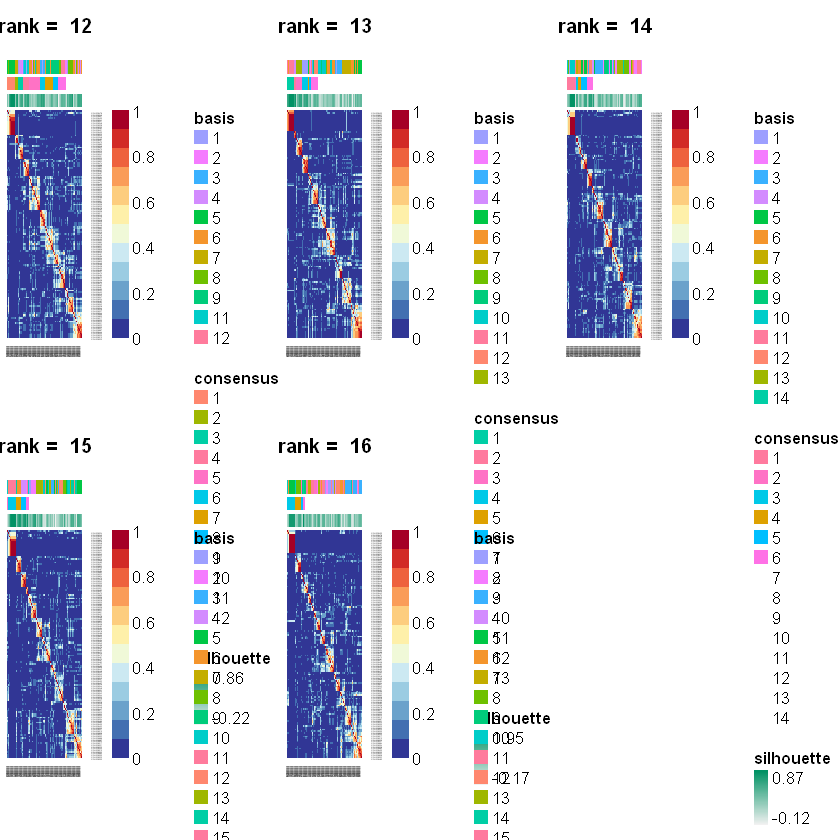

In [10]:

VD_NMF()

In [ ]:
VD_NMF_top_genes <- function(
    #Returns top genes (default 50) differentiating factors.  Top genes are identified by their
    exprs_set,
    k = 14,                     #Number of factors for NMF.
    top_gene_cutoff = 50        #Number of top genes to return.        
    )

    {
    nmf_res <- nmf(sub_nn_exprs, k, method=nmf_method)
    nmf_ls_res <- nmf(sub_nn_exprs, k, method="snmf/l", seed = nmf_res)
                
    #NMF factors matrix V into matrices W (weights) and H (basis).
    #In this case, S = W (sample loadings) and G = H (gene loadings).
    S <- coef(nmf_ls_res)
    G <- basis(nmf_ls_res)

    #Normalize both G and S to make the column means of G = 1
    for (i in 1:14){
        colMean <- mean(G[,i])
        G[,i] <- G[,i] / colMean
        S[i,] <- S[i,] * colMean
    }
    #diff_G is a matrix of differences between gene loading values (G) and the max loading value for that gene (outside of the present)
    #column.

    diff_G <- G

    for (j in 1:14){
        for (i in 1:num_genes){
            diff_G[i, j] <- diff_G[i,j] - max(G[i, -j]) 
        }
    }

    #G3 is the difference absolute values

    absVal_G <- abs(diff_G)

    top_gene_cutoff = 50
    num_samples = 132

    topGenes <- mat.or.vec(top_gene_cutoff,k)

    for(i in 1:14){
        topGenes[,i]<-rownames(head(absVal_G[order(absVal_G[,i], decreasing=TRUE),0],top_gene_cutoff))  
    }
        
    distance_matrix <- dist(t(topGenes))
    hier_clust <- hclust(distance_matrix, method="complete")
    topGenes <- topGenes[,hier_clust$order]
    
    distance_matrix <- dist(topGenes)
    hier_clust <- hclust(distance_matrix, method="complete")
    topGenes <- topGenes[hier_clust$order,]
    
    return(topGenes)         
        
}

In [ ]:
VD_NMF_top_genes(exprs_set = sub_nn_exprs)

In [2]:
gse <- getGEO('GSE21501', GSEMatrix=TRUE)

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
File stored at: 
C:\Users\mayars1\AppData\Local\Temp\Rtmp8OWv4z/GPL4133.soft
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"

$GSE21501_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 45220 features, 132 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM535948 GSM535949 ... GSM536949 (132 total)
  varLabels: title geo_accession ... data_row_count (48 total)
  varMetadata: labelDescription
featureData
  featureNames: 1 2 ... 45220 (45220 total)
  fvarLabels: ID COL ... ORDER (22 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
Annotation: GPL4133 


In [3]:
exprSetGSE <- gse[[1]]


In [12]:
getGEOSuppFiles("GSE21501")

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/suppl/
OK


In [15]:
untar("GSE21501/GSE21501_RAW.tar", exdir="data")

In [16]:
cels <- list.files("data/", pattern = "[gz]")

In [17]:
sapply(paste("data", cels, sep="/"), gunzip)

data/GPL4133_old_annotations.txt.gz 
                           24601413

In [18]:
cels

[1] "GPL4133_old_annotations.txt.gz"

In [20]:
ls data/*.CEL > data/phenodata.txt

ERROR: Error in parse(text = x, srcfile = src): <text>:1:4: unexpected symbol
1: ls data
       ^
